In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Restricted license - for non-production use only - expires 2024-10-28
Obj: 4.154238214520472
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 667.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1268.57it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1053.13it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    # draw plot
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-3
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:   0.9662, Regret: 58.2695%
Epoch  20, Loss:   1.3164, Regret: 31.1433%
Epoch  40, Loss:   0.1405, Regret: 14.2855%
Epoch  60, Loss:   0.1178, Regret: 10.6102%
Epoch  80, Loss:   0.2041, Regret:  9.0000%
Epoch 100, Loss:   0.1488, Regret:  9.1033%
Epoch 120, Loss:   0.2395, Regret:  9.0356%
Epoch 140, Loss:   0.0854, Regret:  9.3832%
Epoch 160, Loss:   0.0956, Regret:  9.5033%
Epoch 180, Loss:   0.0513, Regret:  9.3076%
Elapsed Time: 1.50 Sec


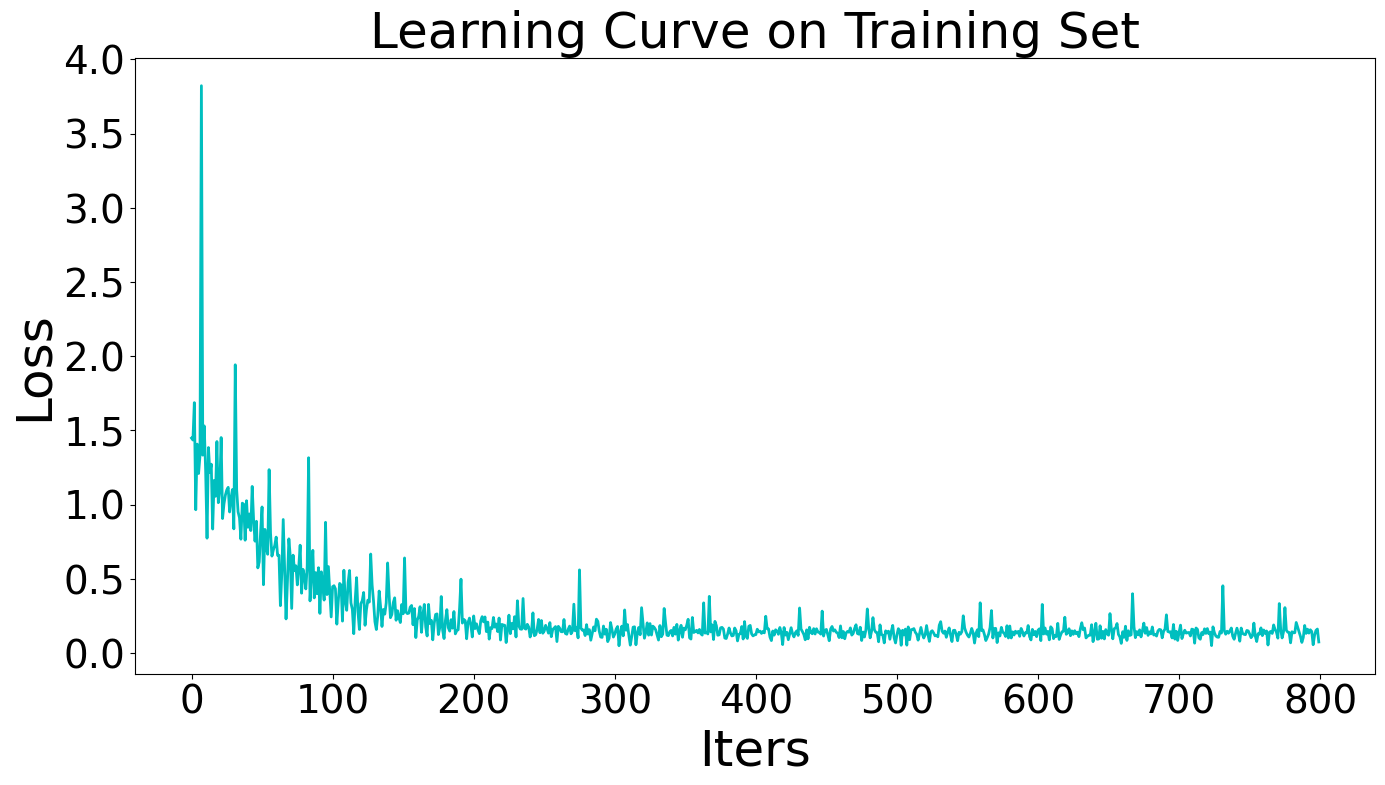

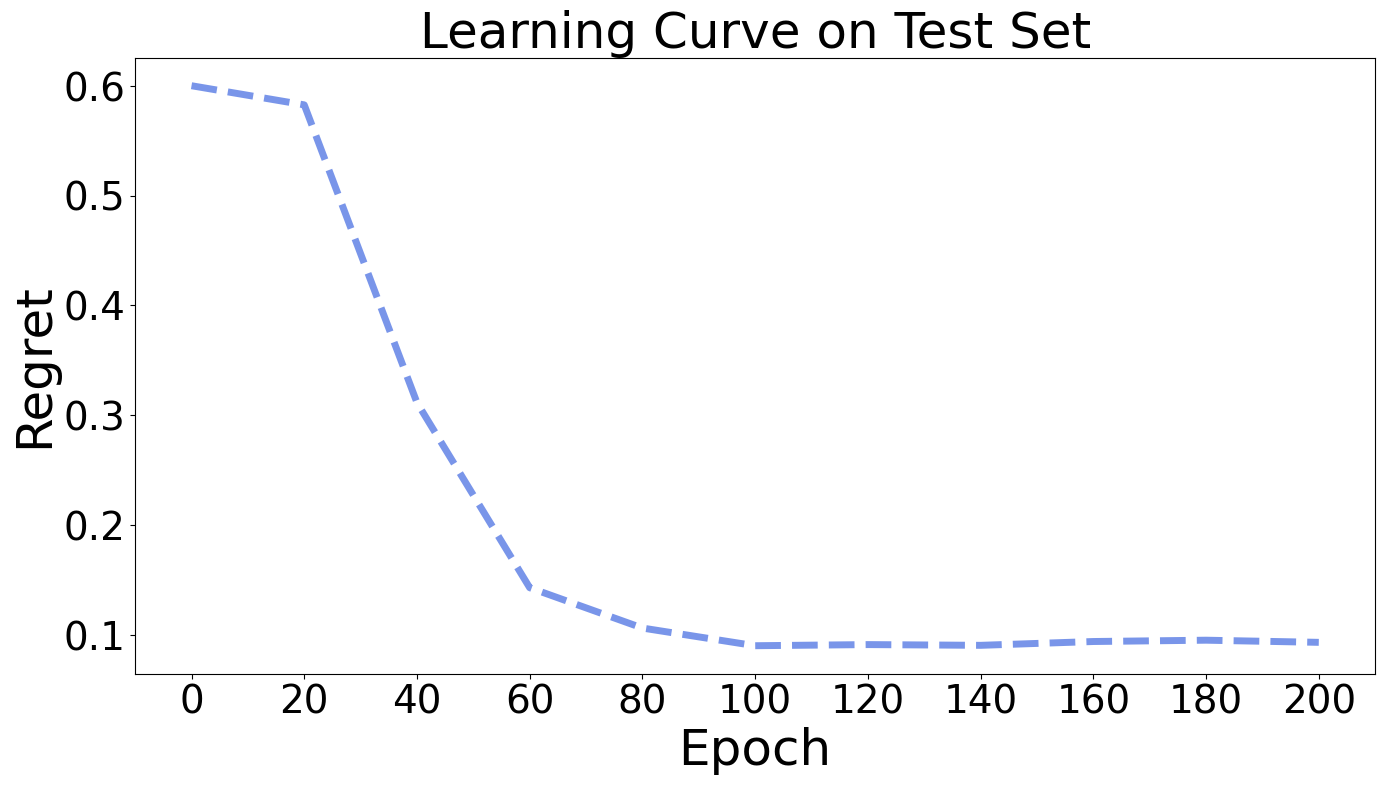

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 5e-3
num_epochs = 200
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9483, Regret: 51.6280%
Epoch  20, Loss:  -0.9990, Regret: 18.9014%
Epoch  40, Loss:  -0.9995, Regret: 13.4628%
Epoch  60, Loss:  -0.9999, Regret: 12.6237%
Epoch  80, Loss:  -0.9998, Regret: 12.9260%
Epoch 100, Loss:  -1.0000, Regret: 12.5858%
Epoch 120, Loss:  -1.0000, Regret: 13.2527%
Epoch 140, Loss:  -0.9999, Regret: 13.4301%
Epoch 160, Loss:  -1.0000, Regret: 13.0039%
Epoch 180, Loss:  -1.0000, Regret: 13.9434%
Elapsed Time: 1203.10 Sec


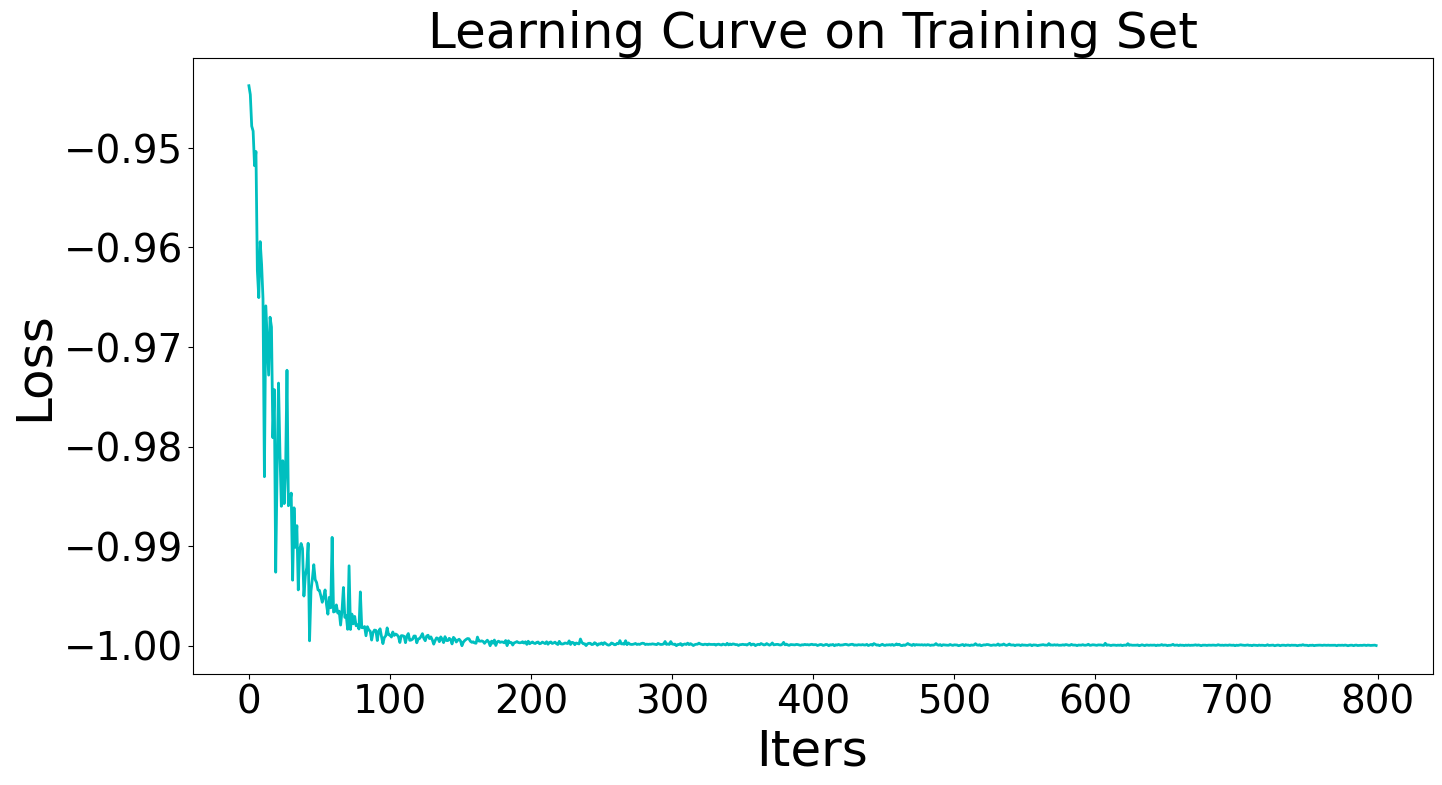

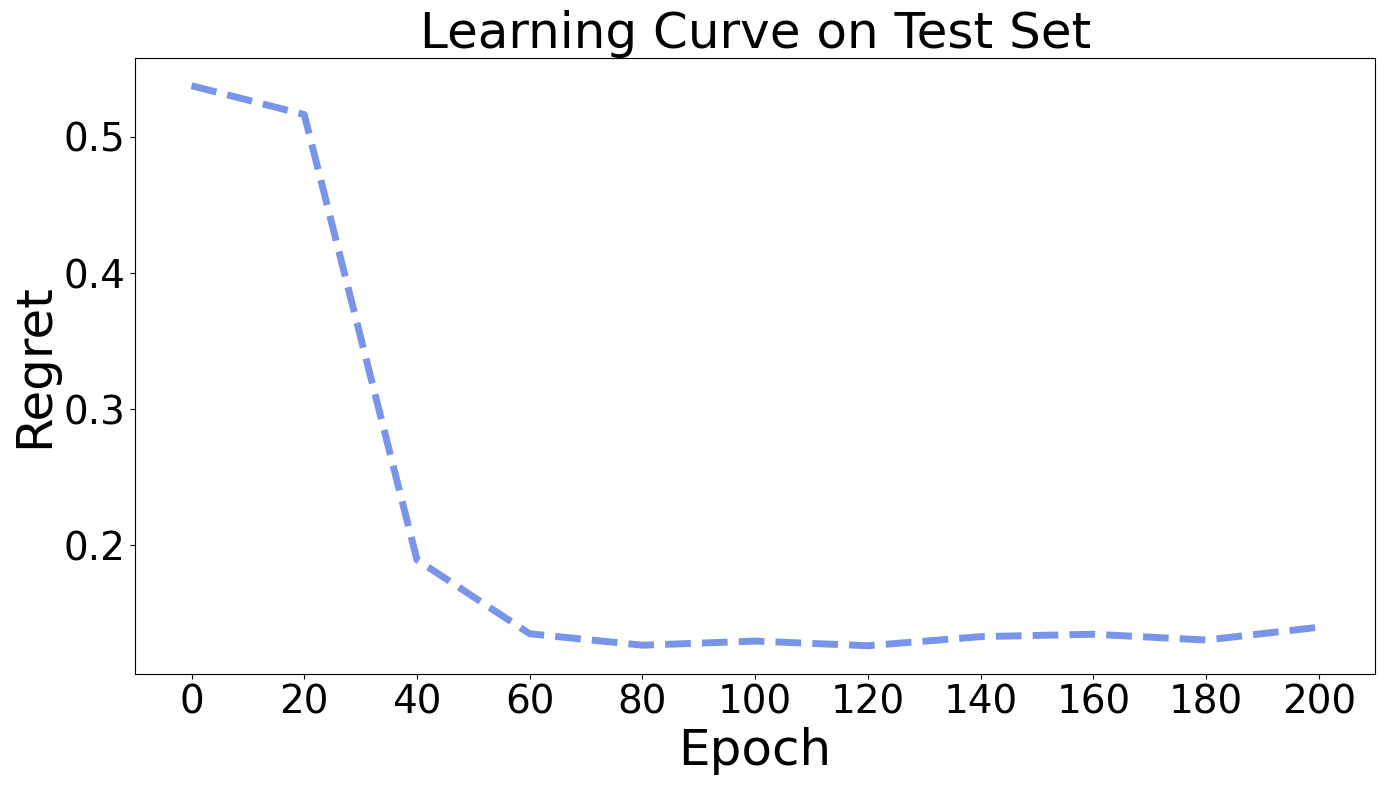

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)

###  Base Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import baseVectConeAlignedCosine
# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [21]:
lr = 5e-3
num_epochs = 200
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.3671, Regret: 49.7297%
Epoch  20, Loss:  -0.6677, Regret: 47.2540%
Epoch  40, Loss:  -0.9040, Regret: 56.2362%
Epoch  60, Loss:  -0.8966, Regret: 50.9562%
Epoch  80, Loss:  -0.9097, Regret: 57.5559%
Epoch 100, Loss:  -0.9760, Regret: 52.0597%
Epoch 120, Loss:  -0.9607, Regret: 50.7511%
Epoch 140, Loss:  -0.9379, Regret: 55.9738%
Epoch 160, Loss:  -0.9133, Regret: 65.3400%
Epoch 180, Loss:  -0.9722, Regret: 57.6865%
Elapsed Time: 0.86 Sec


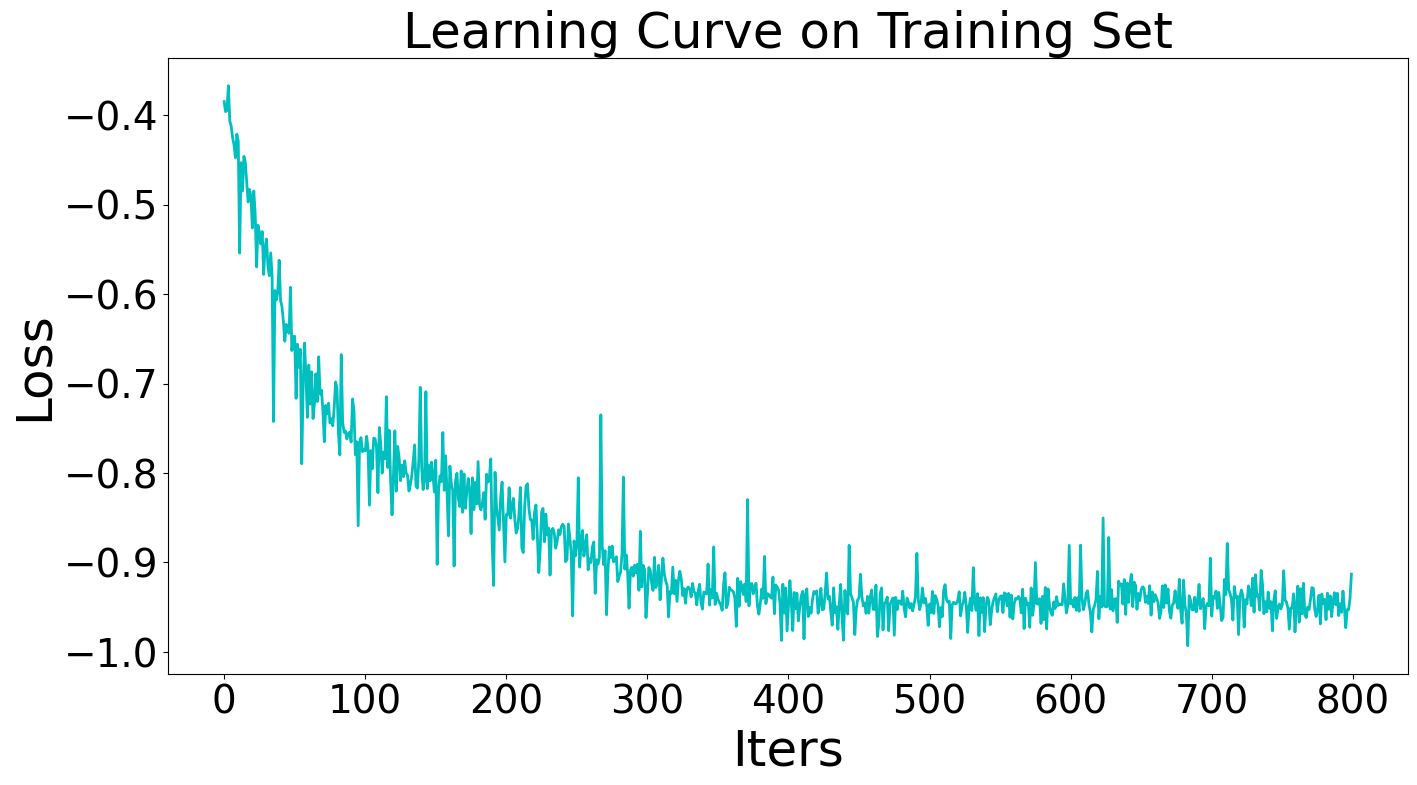

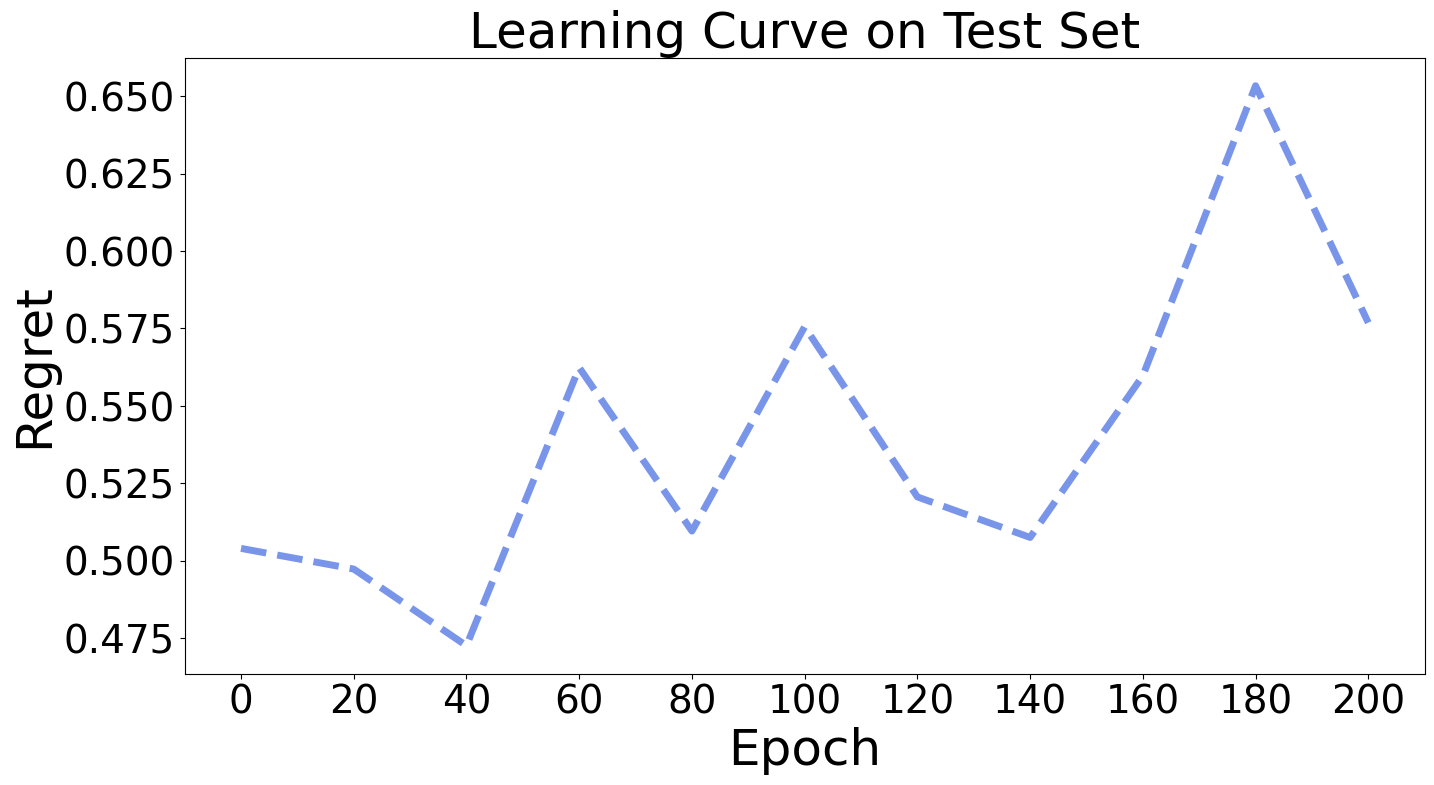

In [22]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 5e-3
num_epochs = 200
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.2720, Regret: 56.9585%
Epoch  20, Loss:  -0.5915, Regret: 18.3952%
Epoch  40, Loss:  -0.6771, Regret: 11.9233%
Epoch  60, Loss:  -0.6953, Regret: 10.8446%
Epoch  80, Loss:  -0.6736, Regret: 11.1927%
Epoch 100, Loss:  -0.7139, Regret: 11.5192%
Epoch 120, Loss:  -0.7221, Regret: 11.8936%
Epoch 140, Loss:  -0.6463, Regret: 11.2906%
Epoch 160, Loss:  -0.6342, Regret: 11.4326%
Epoch 180, Loss:  -0.6611, Regret: 10.6007%
Elapsed Time: 2.37 Sec


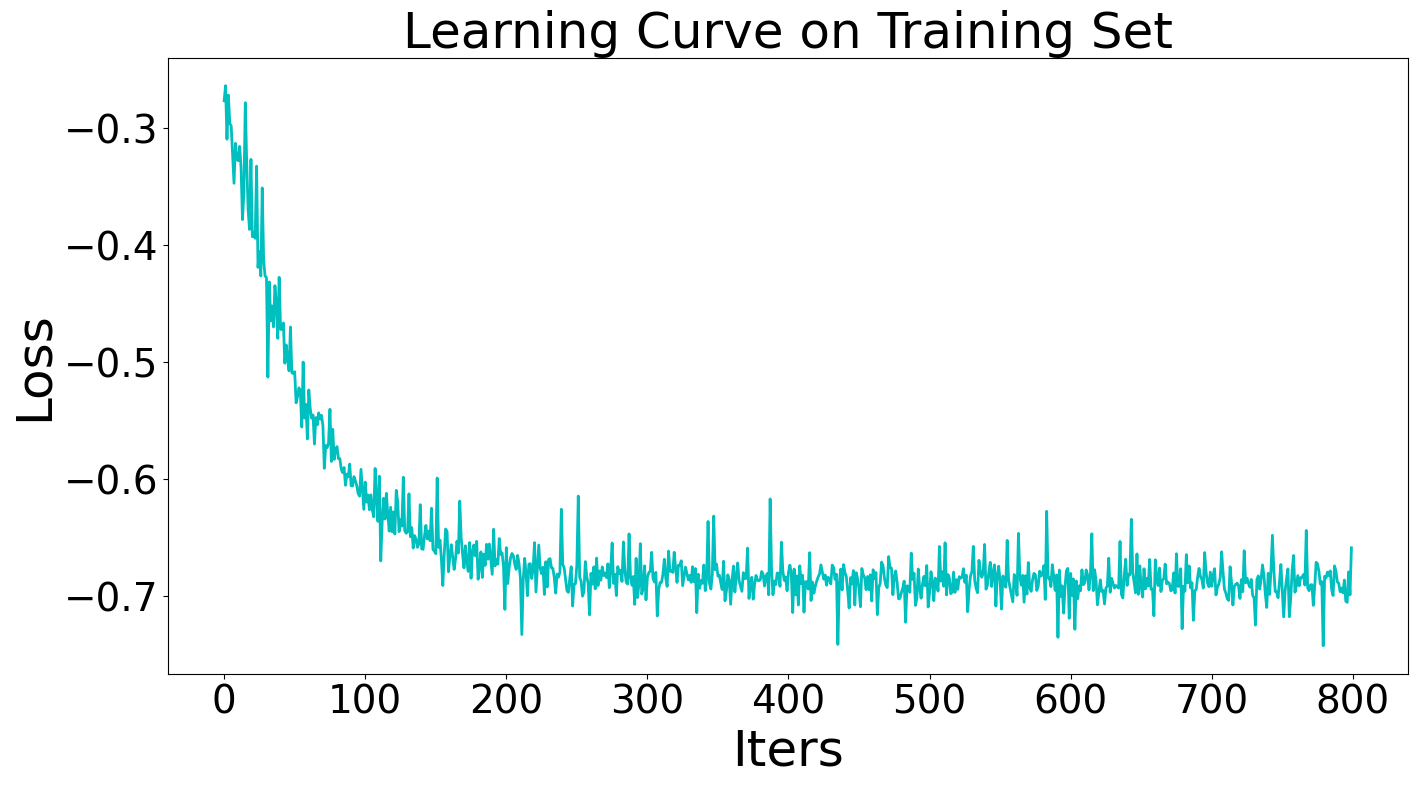

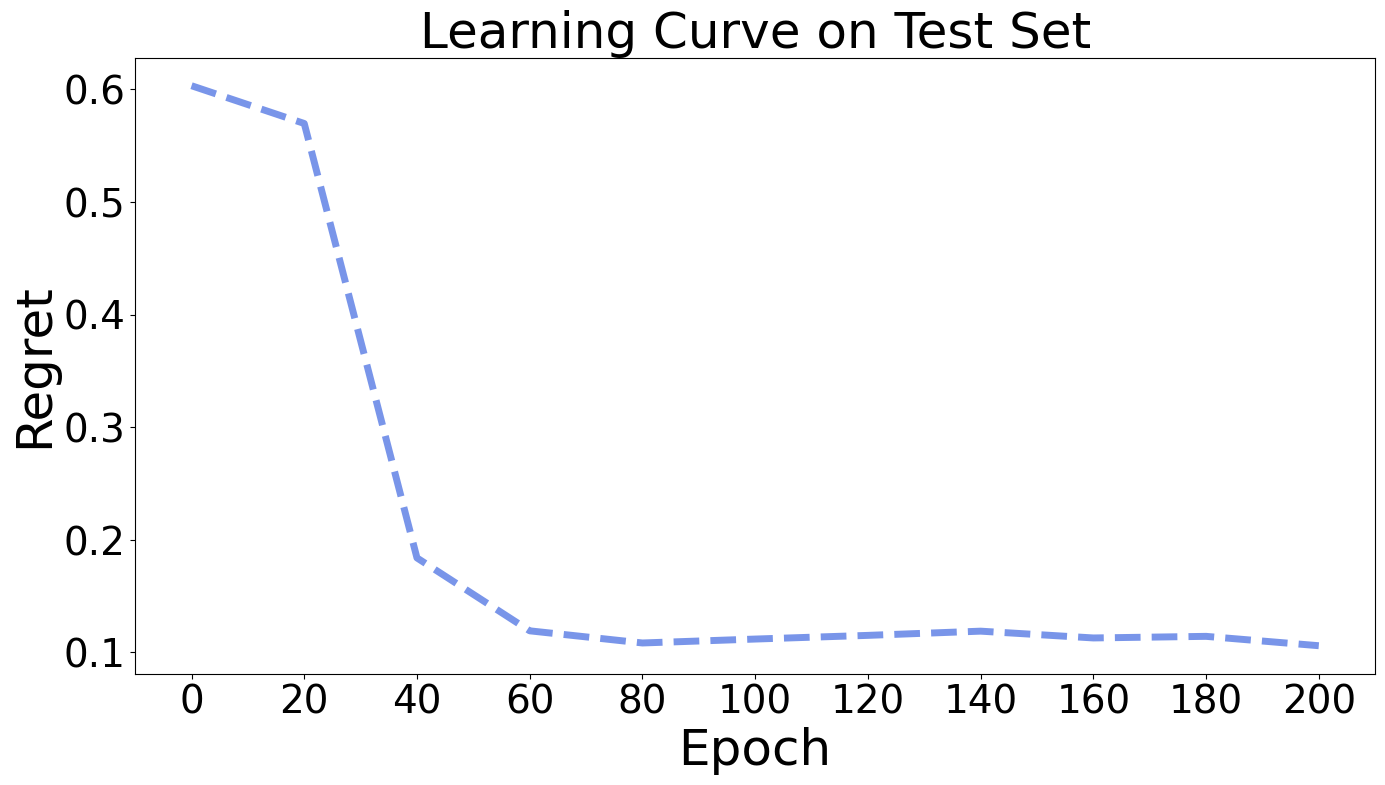

In [26]:
plot(loss_log, regret_log, num_epochs, log_step)

### PFYL 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [29]:
lr = 5e-3
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:   9.1111, Regret: 52.1411%
Epoch  20, Loss:   3.6111, Regret: 14.0452%
Epoch  40, Loss:   4.4444, Regret: 10.1883%
Epoch  60, Loss:   4.0000, Regret: 10.0503%
Epoch  80, Loss:   7.7778, Regret:  9.6137%
Epoch 100, Loss:   8.1667, Regret:  9.4085%
Epoch 120, Loss:   3.1667, Regret:  9.6286%
Epoch 140, Loss:   1.5000, Regret:  9.9283%
Epoch 160, Loss:   2.3333, Regret:  9.9785%
Epoch 180, Loss:   7.1111, Regret: 10.1019%
Elapsed Time: 58.99 Sec


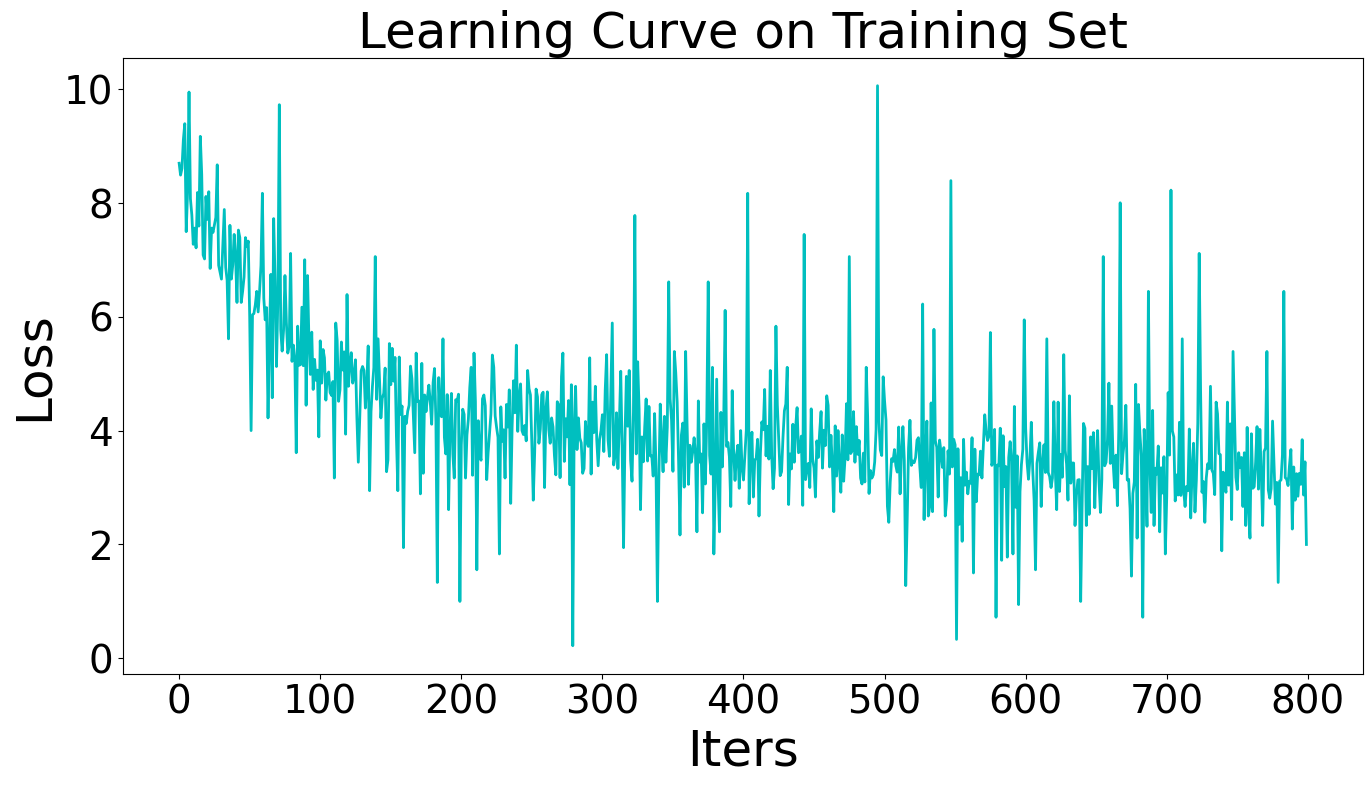

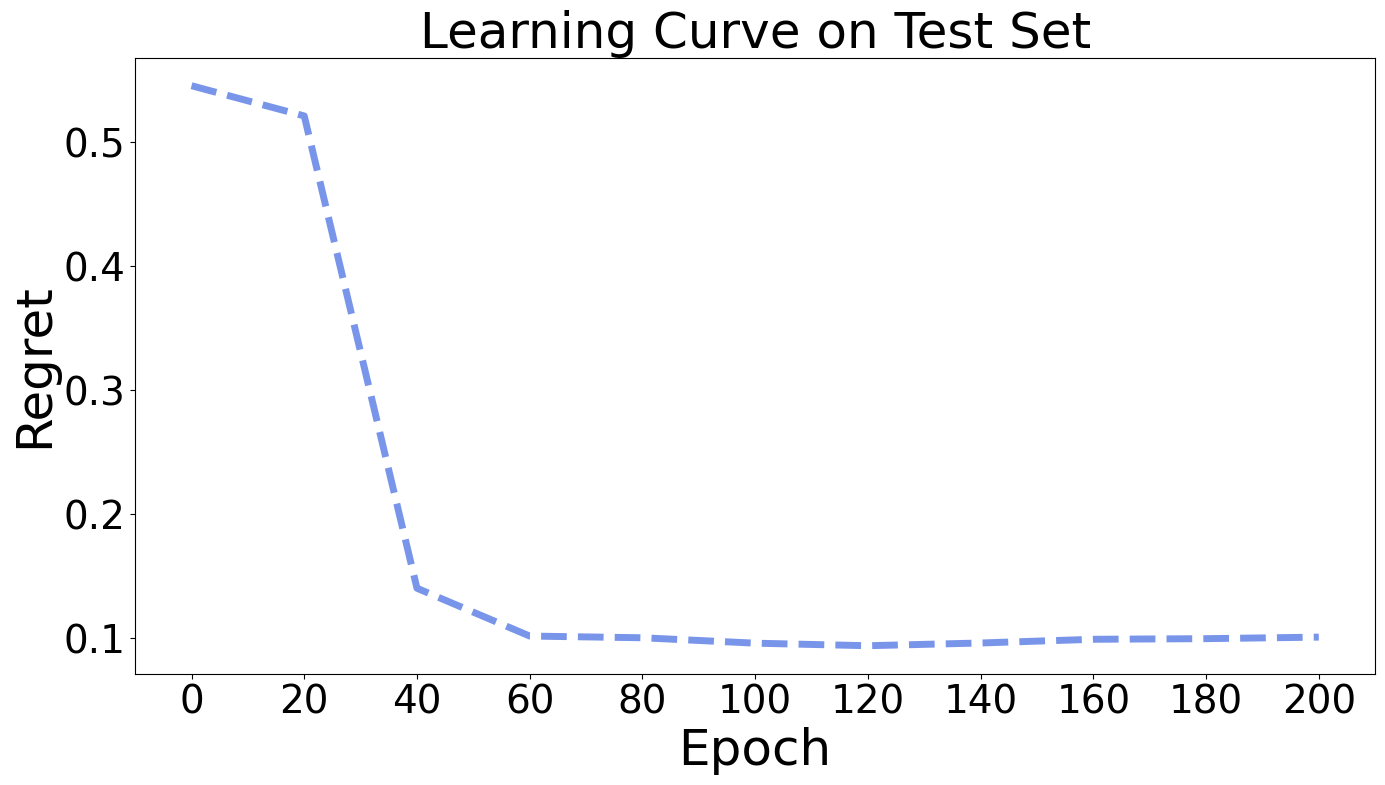

In [30]:
plot(loss_log, regret_log, num_epochs, log_step)